# Simple example using the Menger_Curvature MDAKit 

In this notebook, we will demonstrate how to calculate the Proteic Menger Curvatures (PMCs), the Local Curvatures (LCs) and Local Flexibilities (LFs), first introduced in [1]. 

Consider a triangle. The circumcircle of this triangle (the circle passing through each of its summits) has a radius $R$, and its inverse is called the Menger curvature named after mathematician Karl Menger [2].  We define the PMC($n$) by applying the Menger curvature to the triangle formed by the $C_\alpha$ of residue $n$ and those of residues $n-s$ and $n+s$ where $s$ is defined as the spacing. LC($n$) is the average value of PMC($n$) over all conformations, and LF($n$) is the standard deviation over all conformations. The $n$ subscript can be dropped for clarity and PMCs, LCs and LFs designate the contracted plural forms of the names.

The PMCs characterize the local shape of the polymer in a simplified manner, while the LCs and LFs can be interpreted as the average curvature and as the flexibility of the backbone, respectively.

A full discussion of the Menger_Curvature MDAKit and of the metrics has been released in a Biorxiv preprint [3] : https://www.biorxiv.org/content/10.1101/2025.04.04.647214v1



[1] Marien J, Prévost C, Sacquin-Mora S. nP-Collabs: Investigating Counterion-Mediated Bridges in the Multiply Phosphorylated Tau-R2 Repeat. J Chem Inf Model. 2024 Aug 26;64(16):6570-6582. doi: 10.1021/acs.jcim.4c00742

[2]  Karl Menger, Géométrie Générale, Mémorial des sciences mathématiques, editions Gauthier-Villars

[3] Etienne Reboul, Jules Marien, Chantal Prévost, Antoine Taly, Sophie Sacquin-Mora. Menger_Curvature : a MDAKit implementation to decipher the dynamics, curvatures and flexibilities of polymeric backbones at the residue level bioRxiv 2025.04.04.647214; doi: https://doi.org/10.1101/2025.04.04.647214

## Step 1 : Import the library and your data

We will use the test data, which correspond to the last 1000 frames from a molecular dynamics trajectory of a betaIII tubulin. This protein contains a flexible loop called the M-loop from residues 272-286 and a disordered C-terminal tail (CTT) from residues 427 to 450.  

In [1]:
# Import the libraries for the Menger curvature calculation
import MDAnalysis as mda
from menger.analysis.mengercurvature import MengerCurvature

# Import the test files (not required for regular use)
from menger.data import files
from menger.analysis.visualisation import MengerCurvaturePlotter

# Import the matplotlib.pyplot and numpy packages 
import matplotlib.pyplot as plt 
import numpy as np



/home/etienne-reboul/anaconda3/envs/Menger_Curvature/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
topology = files.TUBULIN_CHAIN_A_PDB # Replace this with the path to your own topology ("path/to/topology.pdb")
trajectory = files.TUBULIN_CHAIN_A_DCD # Replace this with the path to your own trajectory ("path/to/trajectory.dcd")

## Step 2 : Set up the calculation and run it 

In [3]:
# Creating the MDAnalysis universe
u = mda.Universe(topology, trajectory)

/home/etienne-reboul/anaconda3/envs/Menger_Curvature/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


The Menger_Curvature package is built on the class MengerCurvature. 

3 arguments are required :

- The MDAnalysis universe

- select : a selection of the atoms of the backbone on which to perform the calculation. This selection should only contain one chain or part of one chain. We recommend to use the C-alphas for proteins. 

- spacing : This is the $s$ value defined in the introduction. The idea is that the spacing must allow the curvature to be defined on a sufficiently large part of the backbone that a subtantial curvature can be measured. We advise users to know the lowest possible persistence length of their system to make a choice. In the context of proteins, the lowest persistence lengths span around 3 residues, so a spacing of 2 will allow to reach further than this (second nearest neighbors to the central C-alphas)

In [4]:
# Set up the Menger curvature calculation
menger_analyser = MengerCurvature( u,  # Argument 1 : MDAnalysis Universe
                                   select="name CA and chainID A", # Argument 2 : Selection of the atoms on which to calculate the Menger Curvature
                                   spacing=2) # Argument 3 : Spacing. We recommend 2 for protein

Calculation can be launched serially, if the system is small enough (less than 200 residues and/or less than 2000 frames)

In [5]:
# Launch the calculation serially
#menger_analyser.run()

Or calculations can be launched in parallel, which can give a boost in performance for longer trajectories

In [6]:
# Launch the calculation in parallel
menger_analyser.run(backend='multiprocessing', n_workers=4)  # You can change the number of workers depending on your CPU

## Step 3 : Obtaining the results 

For convenience, standard analysis is package as a class called MengerCurvaturePlotter which take as argument :

- Results:   the results of the menger analyser

- Spacing : the spacing used for calculating the menger curvature

This class currently support the creation of 3 plots : 

- Heatmap of the menger cuvervature (residues vs frames) colored by menger curvature value

- Plot the local curvatures (arithmetic mean of menger curvature) along the residues

- Plot the local flexibility (standard deviation of menger curvature) along the residues

In [7]:
menger_plotter = MengerCurvaturePlotter(menger_analyser.results,
                       spacing=menger_analyser.spacing
                       )



### A. Menger Curvatures

The raw results are stored in menger_analyser.results.curvature_array. The shape is (number of frames, number of atoms - 2*$s$)

In [8]:
# First result : the Menger curvatures
menger_curvature = menger_analyser.results.curvature_array
print(menger_curvature.shape)

(1000, 446)


We can plot the menger curvatures to obtain an idea of the dynamics of the system along the conformations. 
In this case, it is an extract from the trajectory of a tubulin, so the frames are time-dependent. 

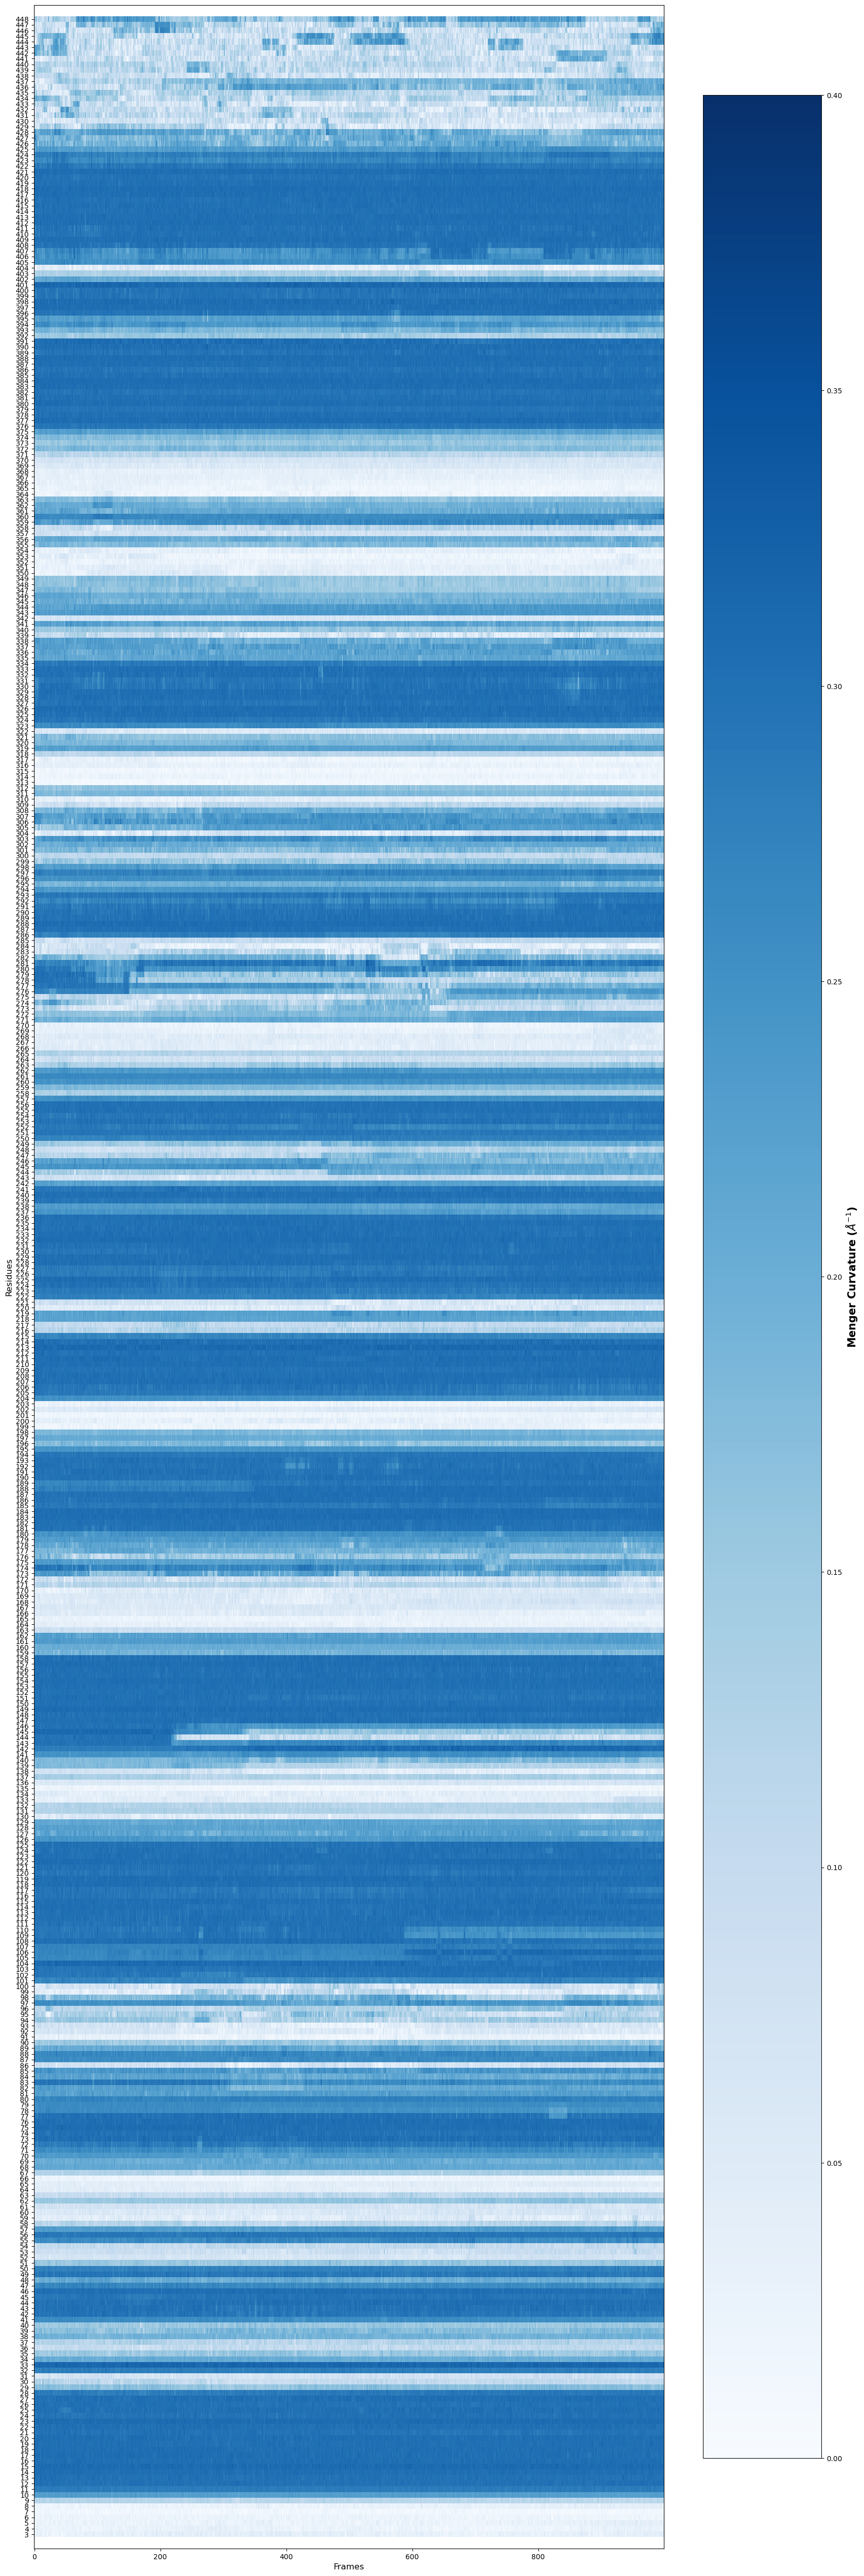

In [9]:
fig=menger_plotter.plot_curvature_heatmap(figsize=(20,65))

We can identify the C-terminal tail (residues 427-450) as its curvature profile changes drastically as the simulation enfolds. 
A few values of interest :
- 0.01 to 0.07 $Å^{-1}$ : most beta-sheets are in this range
- 0.28 to 0.32 $Å^{-1}$ : most alpha-helices are in this range
- 0.00 to 0.35 $Å^{-1}$ : turns, coils and loops 
- 0.37 $Å^{-1}$ : maximum curvature detected in a protein so far

### B. Local Curvatures

The Local Curvatures (LCs) are the average value of the Menger curvatures at a specific atom. LCs are already calculated in menger_analyser.results.local_curvatures. The shape is (number of atoms - 2*$s$)

In [10]:
# Second result : the Local Curvatures = the average curvature per residue
average_curvature = menger_analyser.results.local_curvatures
print(average_curvature.shape)

(446,)


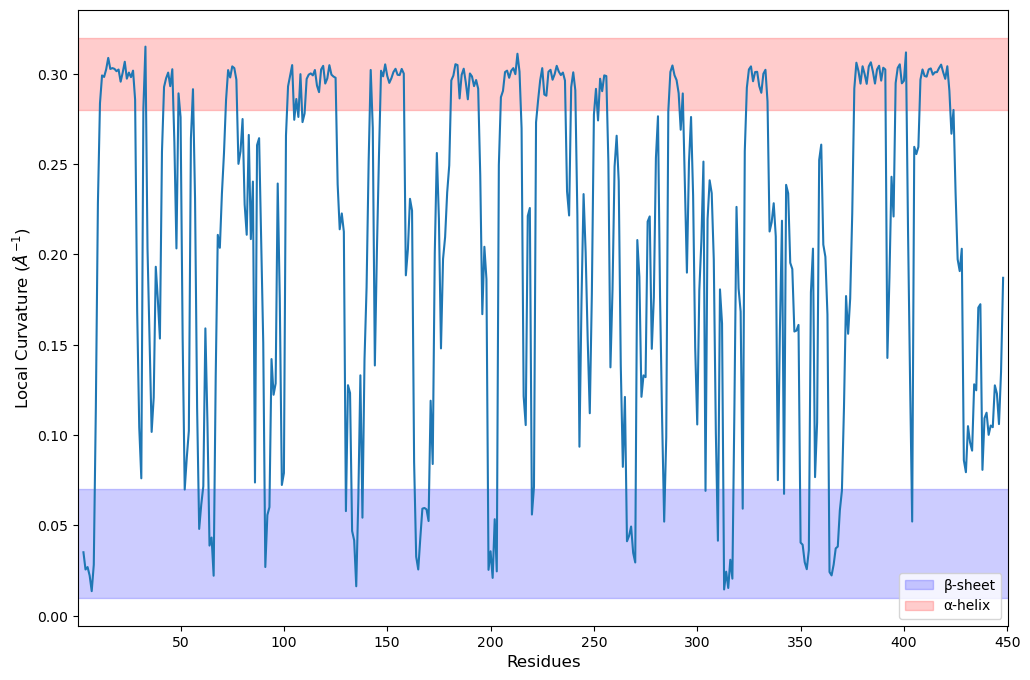

In [15]:
fig=menger_plotter.plot_local_curvature(legend_loc="lower right")

We can clearly visualize the areas which are likely in alpha-helices or beta-sheets. It is also interesting to notice that the disordered C-terminal tail (last 24 residues) does not display the same LC for all residues.

### C. Local Flexibilities

The Local Flexibilities (LFs) are the standard deviation on the Menger curvatures at a specific atom. LFs are already calculated in menger_analyser.results.local_flexibilities. The shape is (number of atoms - 2*$s$)

In [12]:
# Third result : the Local Flexibilities = the standard deviation on the curvature per residue
flexibility = menger_analyser.results.local_flexibilities
print(flexibility.shape)

(446,)


A value of interest is 0.07 $Å^{-1}$. This is the value of the LFs for a polyalanine as computed in :

 Marien J, Prévost C, Sacquin-Mora S. nP-Collabs: Investigating Counterion-Mediated Bridges in the Multiply Phosphorylated Tau-R2 Repeat. J Chem Inf Model. 2024 Aug 26;64(16):6570-6582. doi: 10.1021/acs.jcim.4c00742.

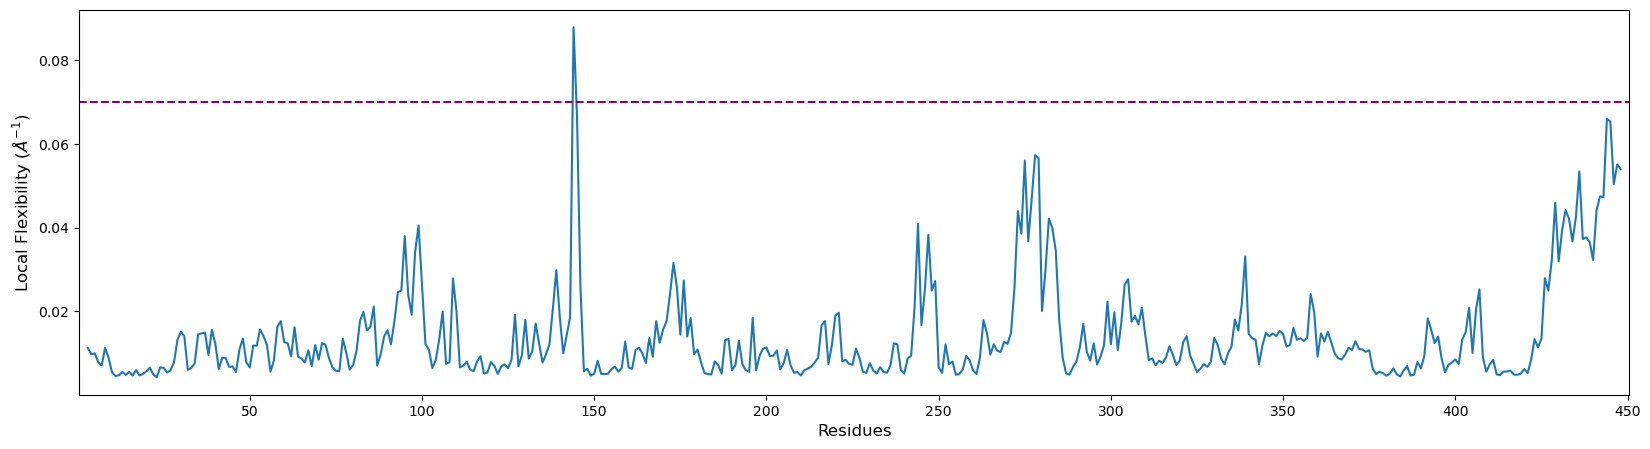

In [13]:
fig = menger_plotter.plot_local_flexibility(figsize=(20,5), threshold=0.07)

We clearly identify the M-loop (residues 272-286) and the C-terminal tail (residues 427-450) as very flexibile compared to the rest of the backbone. Several other smaller loops are visible at residues 93-100, 159-163 and 240-250.  The LFs also detect a strong variation in the curvature of residue 144, a behavior which could call for further analysis or a longer simulation 

# Step 4 : Saving the results

Since the results are contained as numpy arrays in the menger_analyser.results objects, they can easily be saved as .npy files with np.save for example :

In [14]:
for key,value in menger_analyser.results.items():
    np.save(f"tubulin_{key}.npy", value)